In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

In [2]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[i] for i in y if i != padding_index])

In [3]:
dataset = IAMExtendedParagraphs(batch_size=1)
dataset.prepare_data()
dataset.setup()
print(dataset)

2021-06-25 23:50:34.473 | INFO     | text_recognizer.data.iam_paragraphs:setup:107 - Loading IAM paragraph regions and lines for None...
2021-06-25 23:50:50.934 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:79 - IAM Synthetic dataset steup for stage None...


IAM Original and Synthetic Paragraphs Dataset
Num classes: 84
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 19935, 262, 231
Train Batch x stats: (torch.Size([1, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0071), tensor(0.0417), tensor(0.9529))
Train Batch y stats: (torch.Size([1, 682]), torch.int64, tensor(1), tensor(78))
Test Batch x stats: (torch.Size([1, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0372), tensor(0.0767), tensor(0.8118))
Test Batch y stats: (torch.Size([1, 682]), torch.int64, tensor(1), tensor(83))



In [4]:
dataset = IAMParagraphs()
dataset.prepare_data()
dataset.setup()
print(dataset)

2021-06-09 22:01:49.582 | INFO     | text_recognizer.data.iam_paragraphs:setup:107 - Loading IAM paragraph regions and lines for None...


IAM Paragraphs Dataset
Num classes: 84
Input dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 1046, 262, 231
Train Batch x stats: (torch.Size([16, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0330), tensor(0.0985), tensor(1.))
Train Batch y stats: (torch.Size([16, 682]), torch.int64, tensor(1), tensor(83))
Test Batch x stats: (torch.Size([16, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0312), tensor(0.0817), tensor(0.9294))
Test Batch y stats: (torch.Size([16, 682]), torch.int64, tensor(1), tensor(83))



In [4]:
x, y = dataset.data_train[1]

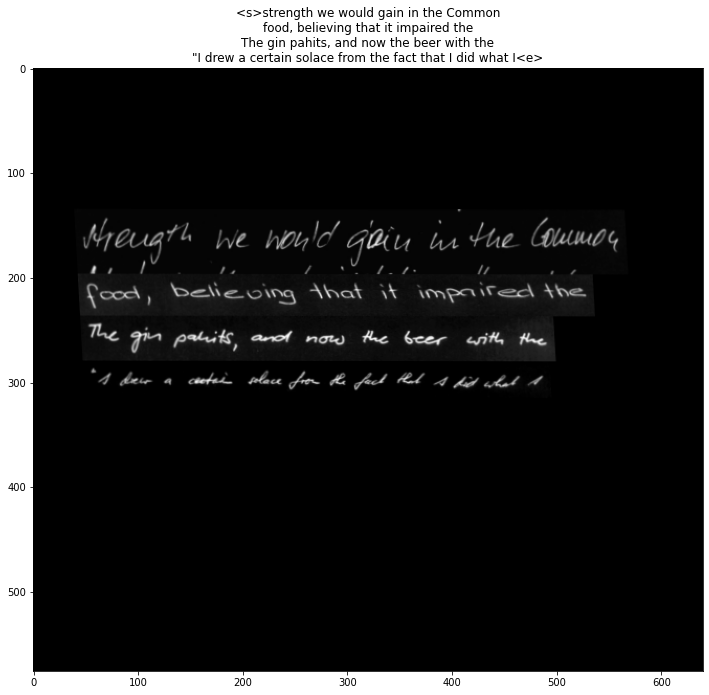

In [13]:
_plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

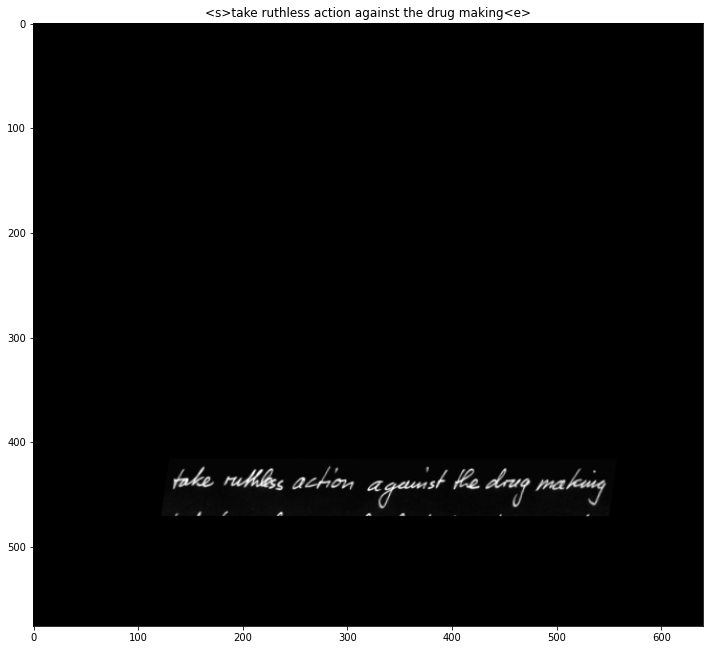

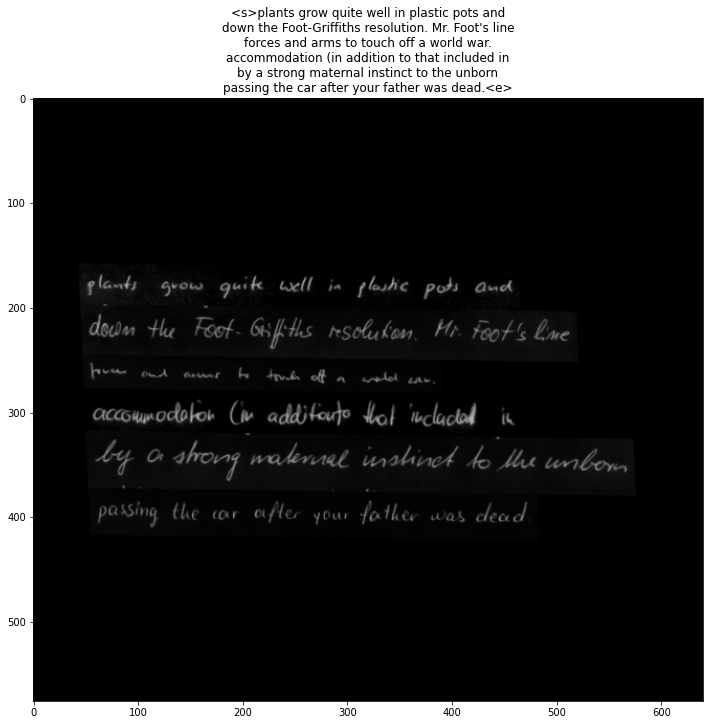

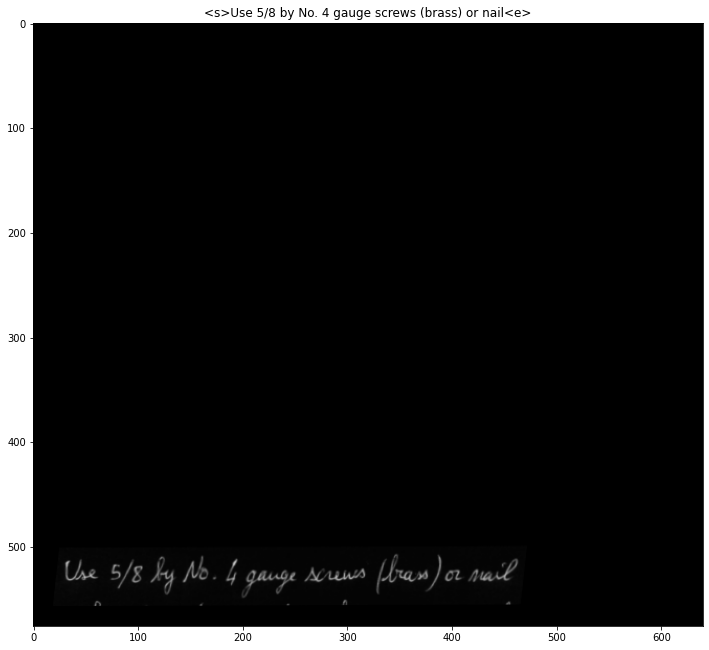

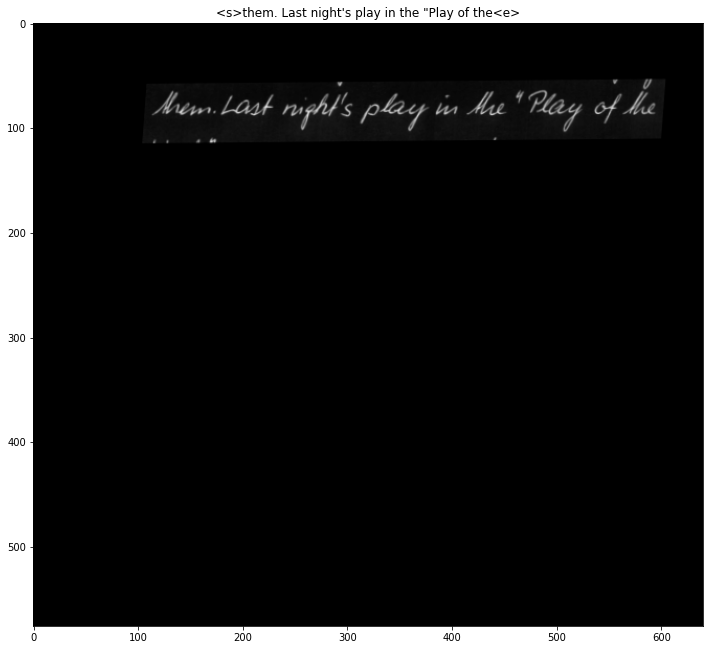

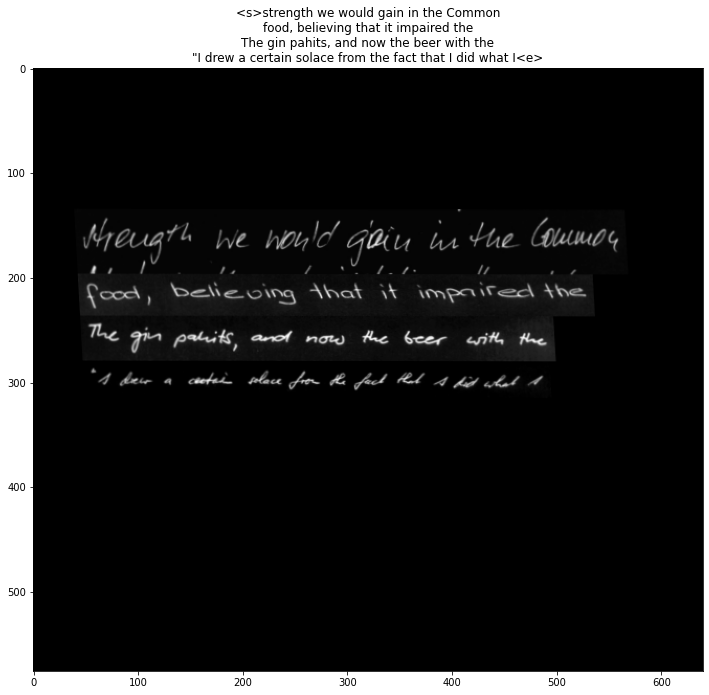

In [5]:
# Training

for _ in range(5):
    i = random.randint(0, len(dataset.data_train))
    x, y = dataset.data_train[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [7]:
from einops import rearrange

In [8]:
x, y = dataset.data_train[2]

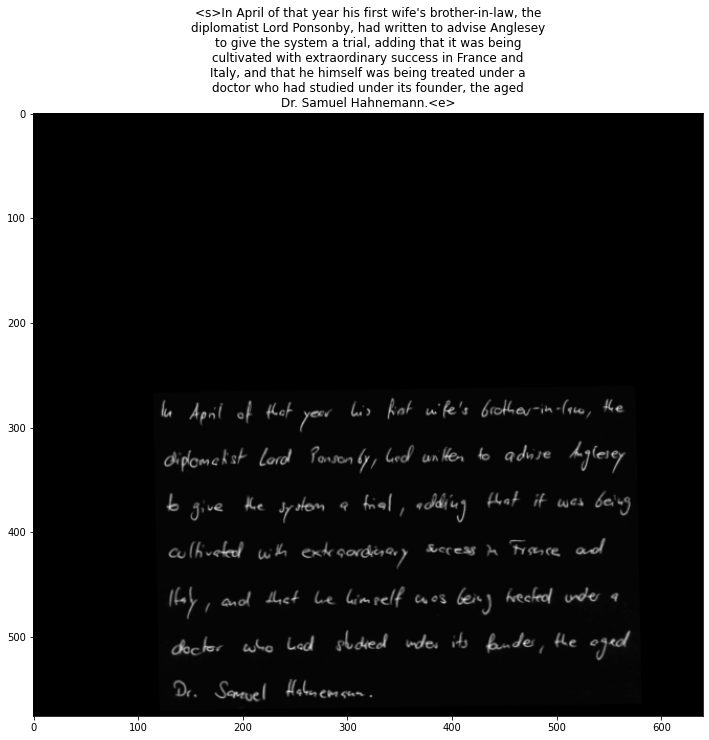

In [9]:
_plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [15]:
p = 32
patches = rearrange(x.unsqueeze(0), 'b c (h p1) (w p2) -> b c (h w) p1 p2', p1 = p, p2 = p)

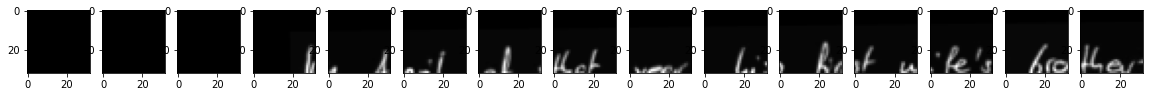

In [19]:
fig = plt.figure(figsize=(20, 20))
for i in range(15):
    ax = fig.add_subplot(1, 15, i + 1)
    ax.imshow(patches[0, 0, i + 160, :, :].squeeze(0), cmap='gray')

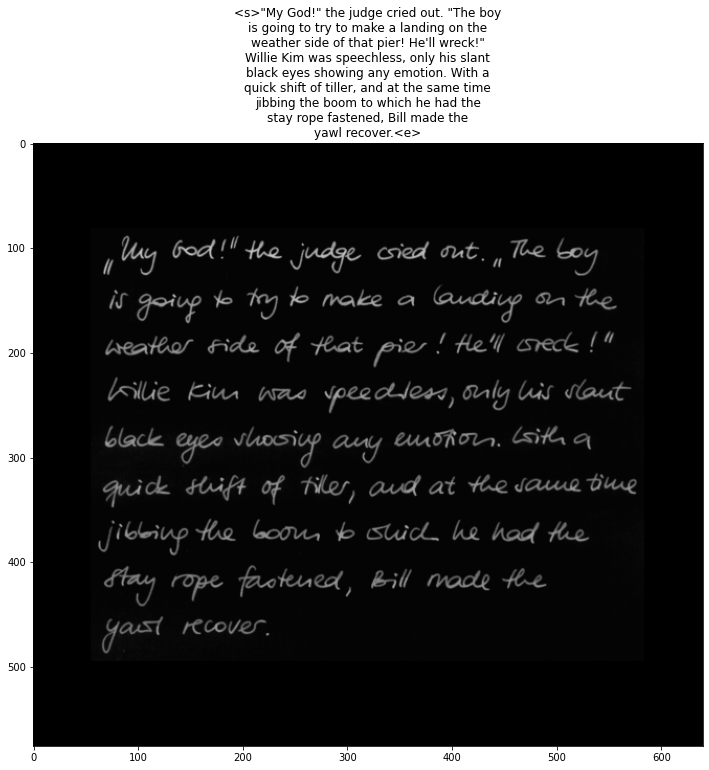

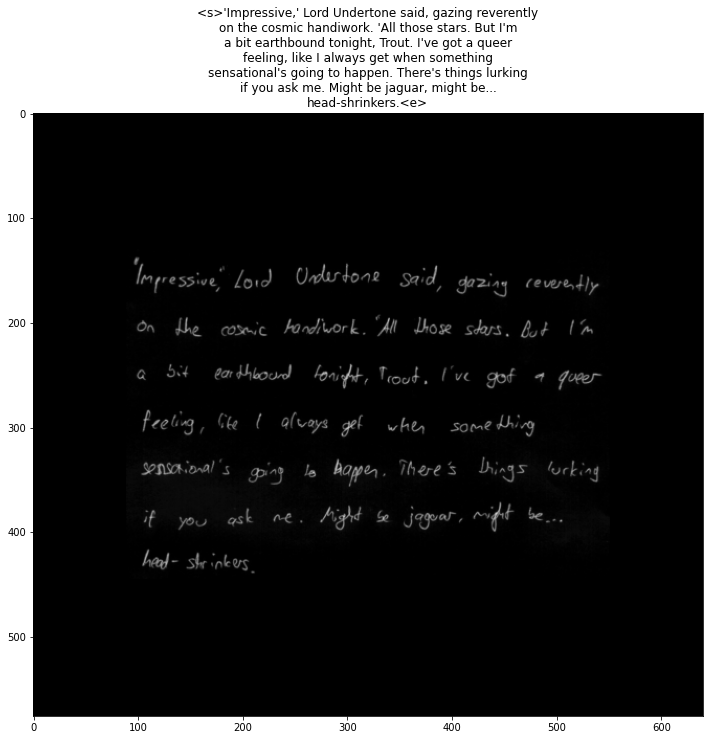

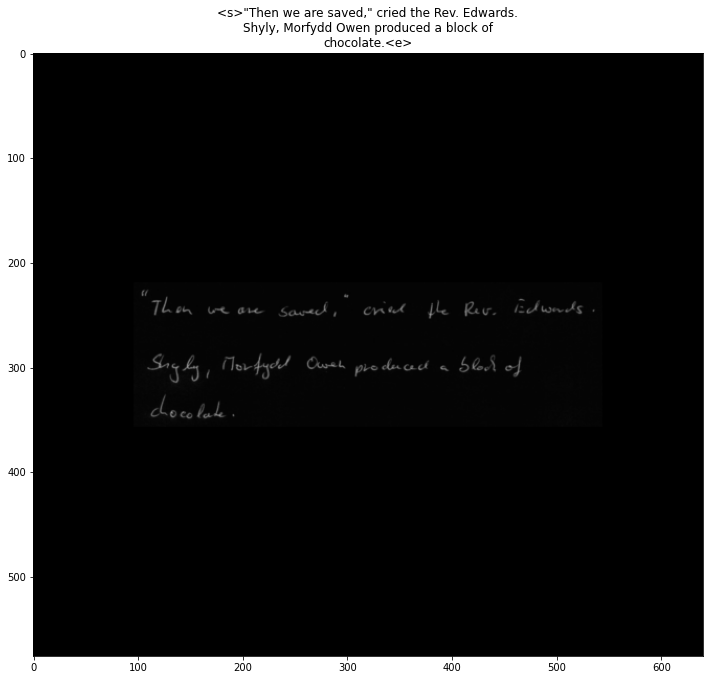

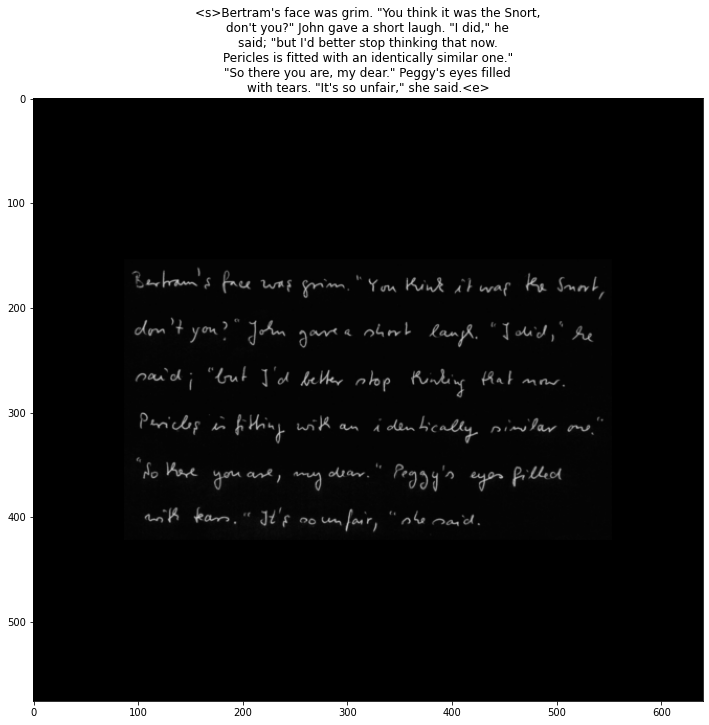

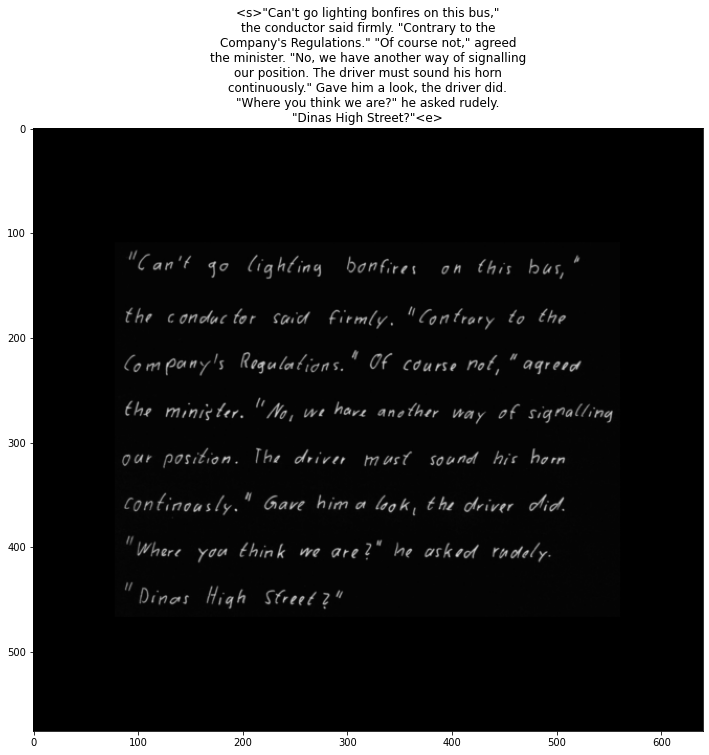

In [9]:
# Testing

for _ in range(5):
    i = random.randint(0, len(dataset.data_test))
    x, y = dataset.data_test[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))

In [10]:
dataset = IAMSyntheticParagraphs()
dataset.prepare_data()
dataset.setup()
print(dataset)

2021-04-16 23:12:51.653 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:79 - IAM Synthetic dataset steup for stage None


IAM Synthetic Paragraphs Dataset
Num classes: 84
Input dims : (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 18906, 0, 0
Train Batch x stats: (torch.Size([16, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0097), tensor(0.0528), tensor(0.9961))
Train Batch y stats: (torch.Size([16, 682]), torch.int64, tensor(1), tensor(83))



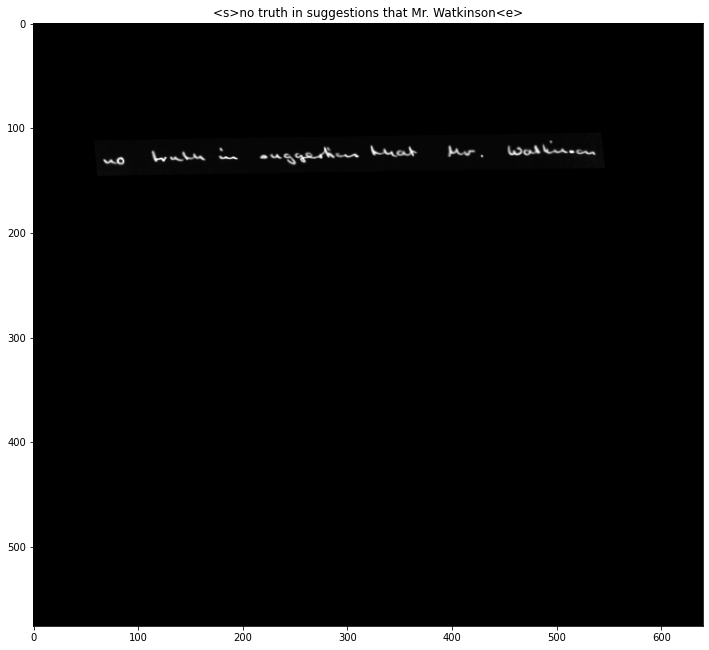

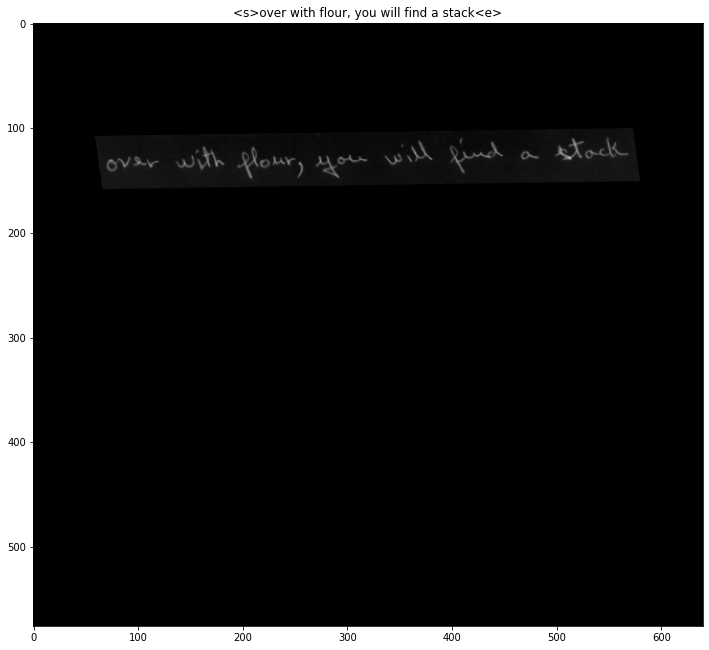

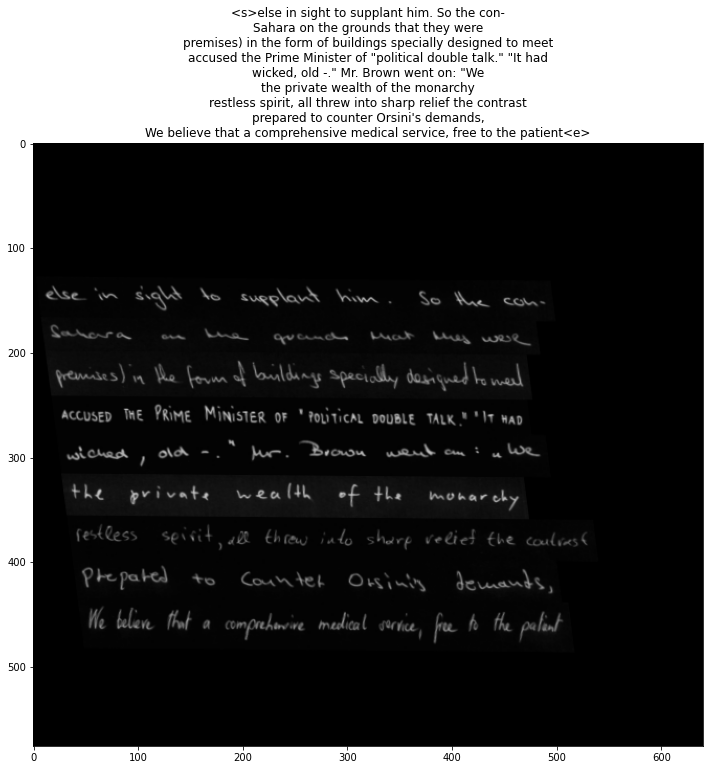

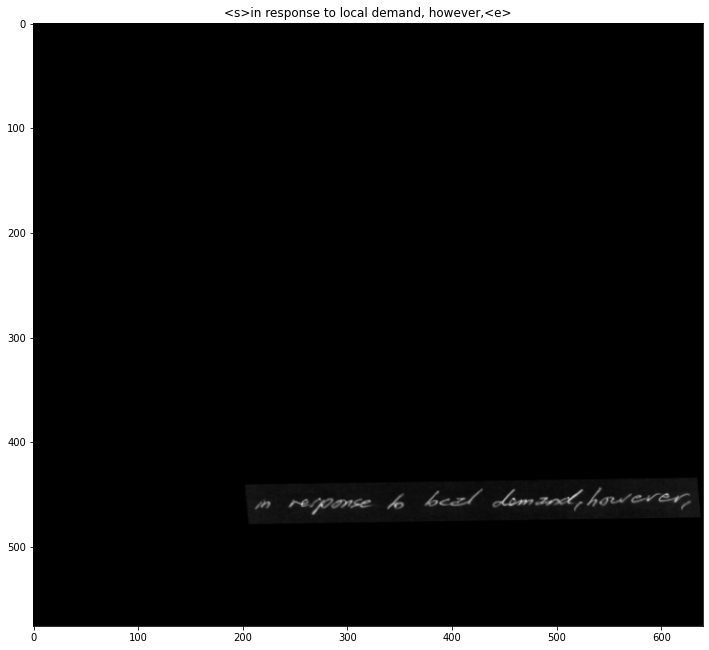

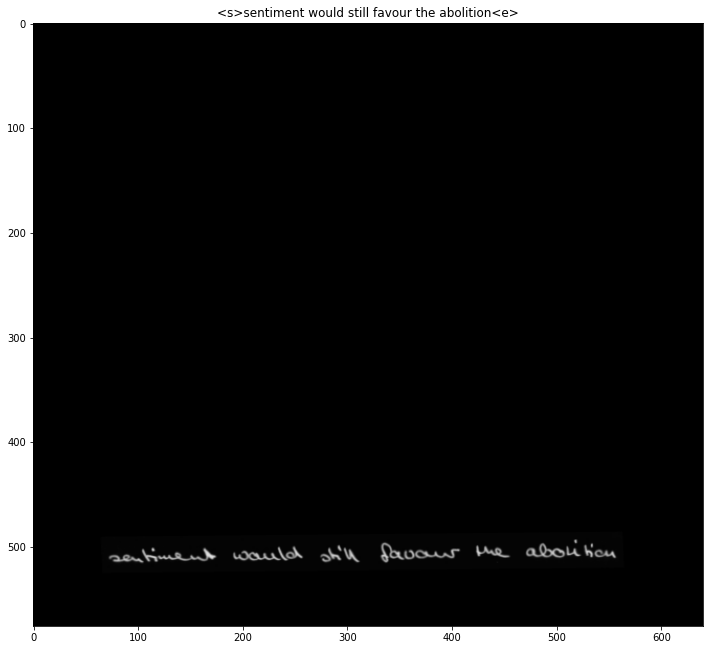

In [11]:
# Training

for _ in range(5):
    i = random.randint(0, len(dataset.data_train))
    x, y = dataset.data_train[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, dataset.mapping))